In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [2]:
%autoreload

In [3]:
lcs_g = utils.get_data('../../datasets/ZTF_g', split=1.0)
lcs_i = utils.get_data('../../datasets/ZTF_i', split=1.0)
lcs_r =  utils.get_data('../../datasets/ZTF_r', split=1.0)

validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2559, 1, 1974, 3)
train size: 2559, valid size: 0, test size: 0
validated 3399 files out of 3399 for band='i'
created union_tp attribute of length 3500
dataset created w/ shape (1726, 1, 539, 3)
train size: 1726, valid size: 0, test size: 0
validated 3398 files out of 3398 for band='r'
created union_tp attribute of length 3500
dataset created w/ shape (2606, 1, 2011, 3)
train size: 2606, valid size: 0, test size: 0


In [4]:
net_g, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_g0.668415367603302.h5', lcs_g.data_obj)
net_r, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_r0.8139369487762451.h5', lcs_r.data_obj)
net_i, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/i/ZTF_i-0.039828985929489136.h5', lcs_i.data_obj)


=> loading checkpoint '../checkpoints/final/ZTF_g0.668415367603302.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_g', checkpoint='datasets/ZTF_g0.7037358283996582.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-06, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)
=> loading checkpoint '../checkpoints/final/ZTF_r0.8139369487762451.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_r', checkpoint='datasets/ZTF_r0.8400019407272339.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100,

In [5]:
lcs_rm_g = utils.get_data('../../datasets/ZTF_rm_g', split=1.0)
lcs_rm_r = utils.get_data('../../datasets/ZTF_rm_r', split=1.0)
lcs_rm_i = utils.get_data('../../datasets/ZTF_rm_i', split=1.0)

validated 10 files out of 10 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (8, 1, 1312, 3)
train size: 8, valid size: 0, test size: 0
validated 9 files out of 9 for band='r'
created union_tp attribute of length 3500
dataset created w/ shape (8, 1, 1360, 3)
train size: 8, valid size: 0, test size: 0
validated 10 files out of 10 for band='i'
created union_tp attribute of length 3500
dataset created w/ shape (5, 1, 319, 3)
train size: 5, valid size: 0, test size: 0


In [6]:
qzs_rm_g,disc_path_rm_g = utils.encode(lcs_rm_g.data_obj['train_loader'], net_g, device='mps')
qzs_rm_i,disc_path_rm_i = utils.encode(lcs_rm_i.data_obj['train_loader'], net_i, device='mps')
qzs_rm_r,disc_path_rm_r = utils.encode(lcs_rm_r.data_obj['train_loader'], net_r, device='mps')

  0%|                                                                                                                                                                       | 0/4 [00:00<?, ?it/s]/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:84: UserWarning: The operator 'aten::repeat_interleave.self_int' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1660029059141/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 45.00it/s]


In [7]:
## or 
lcs_rm_g.set_target_x(500)
lcs_rm_r.set_target_x(500)
lcs_rm_i.set_target_x(500)


In [10]:
## take samples from qz, decode separately, then average the interpolations 
n_samples = 10


zs_rm_g = (np.random.randn(n_samples, qzs_rm_g.shape[0], qzs_rm_g.shape[2],qzs_rm_g.shape[3]) * qzs_rm_g[:,1,:,:] + qzs_rm_g[:,0,:,:])
zs_rm_r = (np.random.randn(n_samples, qzs_rm_r.shape[0], qzs_rm_r.shape[2],qzs_rm_r.shape[3]) * qzs_rm_r[:,1,:,:] + qzs_rm_r[:,0,:,:])
zs_rm_i = (np.random.randn(n_samples, qzs_rm_i.shape[0], qzs_rm_i.shape[2],qzs_rm_i.shape[3]) * qzs_rm_i[:,1,:,:] + qzs_rm_i[:,0,:,:])

In [8]:
# interp to good resolution + target_x 
# show interps for objects w/ decent losses? 
# run eval on a bunch to see which don't suck?
# evaluate_loss diff then train loss? yyyyyyyy
# make sure shuffles r actually working right 


In [11]:
interps_rm_g = np.array([utils.decode(net_g,z[:10],disc_path_rm_g[:10],lcs_rm_g.target_x[:10]) for z in zs_rm_g])
interps_rm_i = np.array([utils.decode(net_i,z[:10],disc_path_rm_i[:10],lcs_rm_i.target_x[:10]) for z in zs_rm_i])
interps_rm_r = np.array([utils.decode(net_r,z[:10],disc_path_rm_r[:10],lcs_rm_r.target_x[:10]) for z in zs_rm_r])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


In [12]:
t_rm_g = interps_rm_g[0,:,:,:,0]
y_avg_rm_g = interps_rm_g[:,:,:,:,1].mean(0)
yerr_avg_rm_g = interps_rm_g[:,:,:,:,2].mean(0)
intps_rm_g = np.concatenate((t_rm_g[np.newaxis],y_avg_rm_g[np.newaxis],yerr_avg_rm_g[np.newaxis]),axis=0).transpose(1,2,3,0)

In [13]:
t_rm_i = interps_rm_i[0,:,:,:,0]
y_avg_rm_i = interps_rm_i[:,:,:,:,1].mean(0)
yerr_avg_rm_i = interps_rm_i[:,:,:,:,2].mean(0)
intps_rm_i = np.concatenate((t_rm_i[np.newaxis],y_avg_rm_i[np.newaxis],yerr_avg_rm_i[np.newaxis]),axis=0).transpose(1,2,3,0)

In [14]:
t_rm_r = interps_rm_r[0,:,:,:,0]
y_avg_rm_r = interps_rm_r[:,:,:,:,1].mean(0)
yerr_avg_rm_r = interps_rm_r[:,:,:,:,2].mean(0)
intps_rm_r = np.concatenate((t_rm_r[np.newaxis],y_avg_rm_r[np.newaxis],yerr_avg_rm_r[np.newaxis]),axis=0).transpose(1,2,3,0)

## UNNORMALIZE

In [15]:
for i, object_lcs in enumerate(lcs_rm_g.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps_rm_g[i,j,:,0] = intps_rm_g[i,j,:,0] + min_t
            intps_rm_g[i,j,:,1] = (intps_rm_g[i,j,:,1] * std) + mean  
            intps_rm_g[i,j,:,2] = (intps_rm_g[i,j,:,2] * std)


In [16]:
for i, object_lcs in enumerate(lcs_rm_r.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps_rm_r[i,j,:,0] = intps_rm_r[i,j,:,0] + min_t
            intps_rm_r[i,j,:,1] = (intps_rm_r[i,j,:,1] * std) + mean  
            intps_rm_r[i,j,:,2] = (intps_rm_r[i,j,:,2] * std)

In [17]:
for i, object_lcs in enumerate(lcs_rm_i.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps_rm_i[i,j,:,0] = intps_rm_i[i,j,:,0] + min_t
            intps_rm_i[i,j,:,1] = (intps_rm_i[i,j,:,1] * std) + mean  
            intps_rm_i[i,j,:,2] = (intps_rm_i[i,j,:,2] * std)

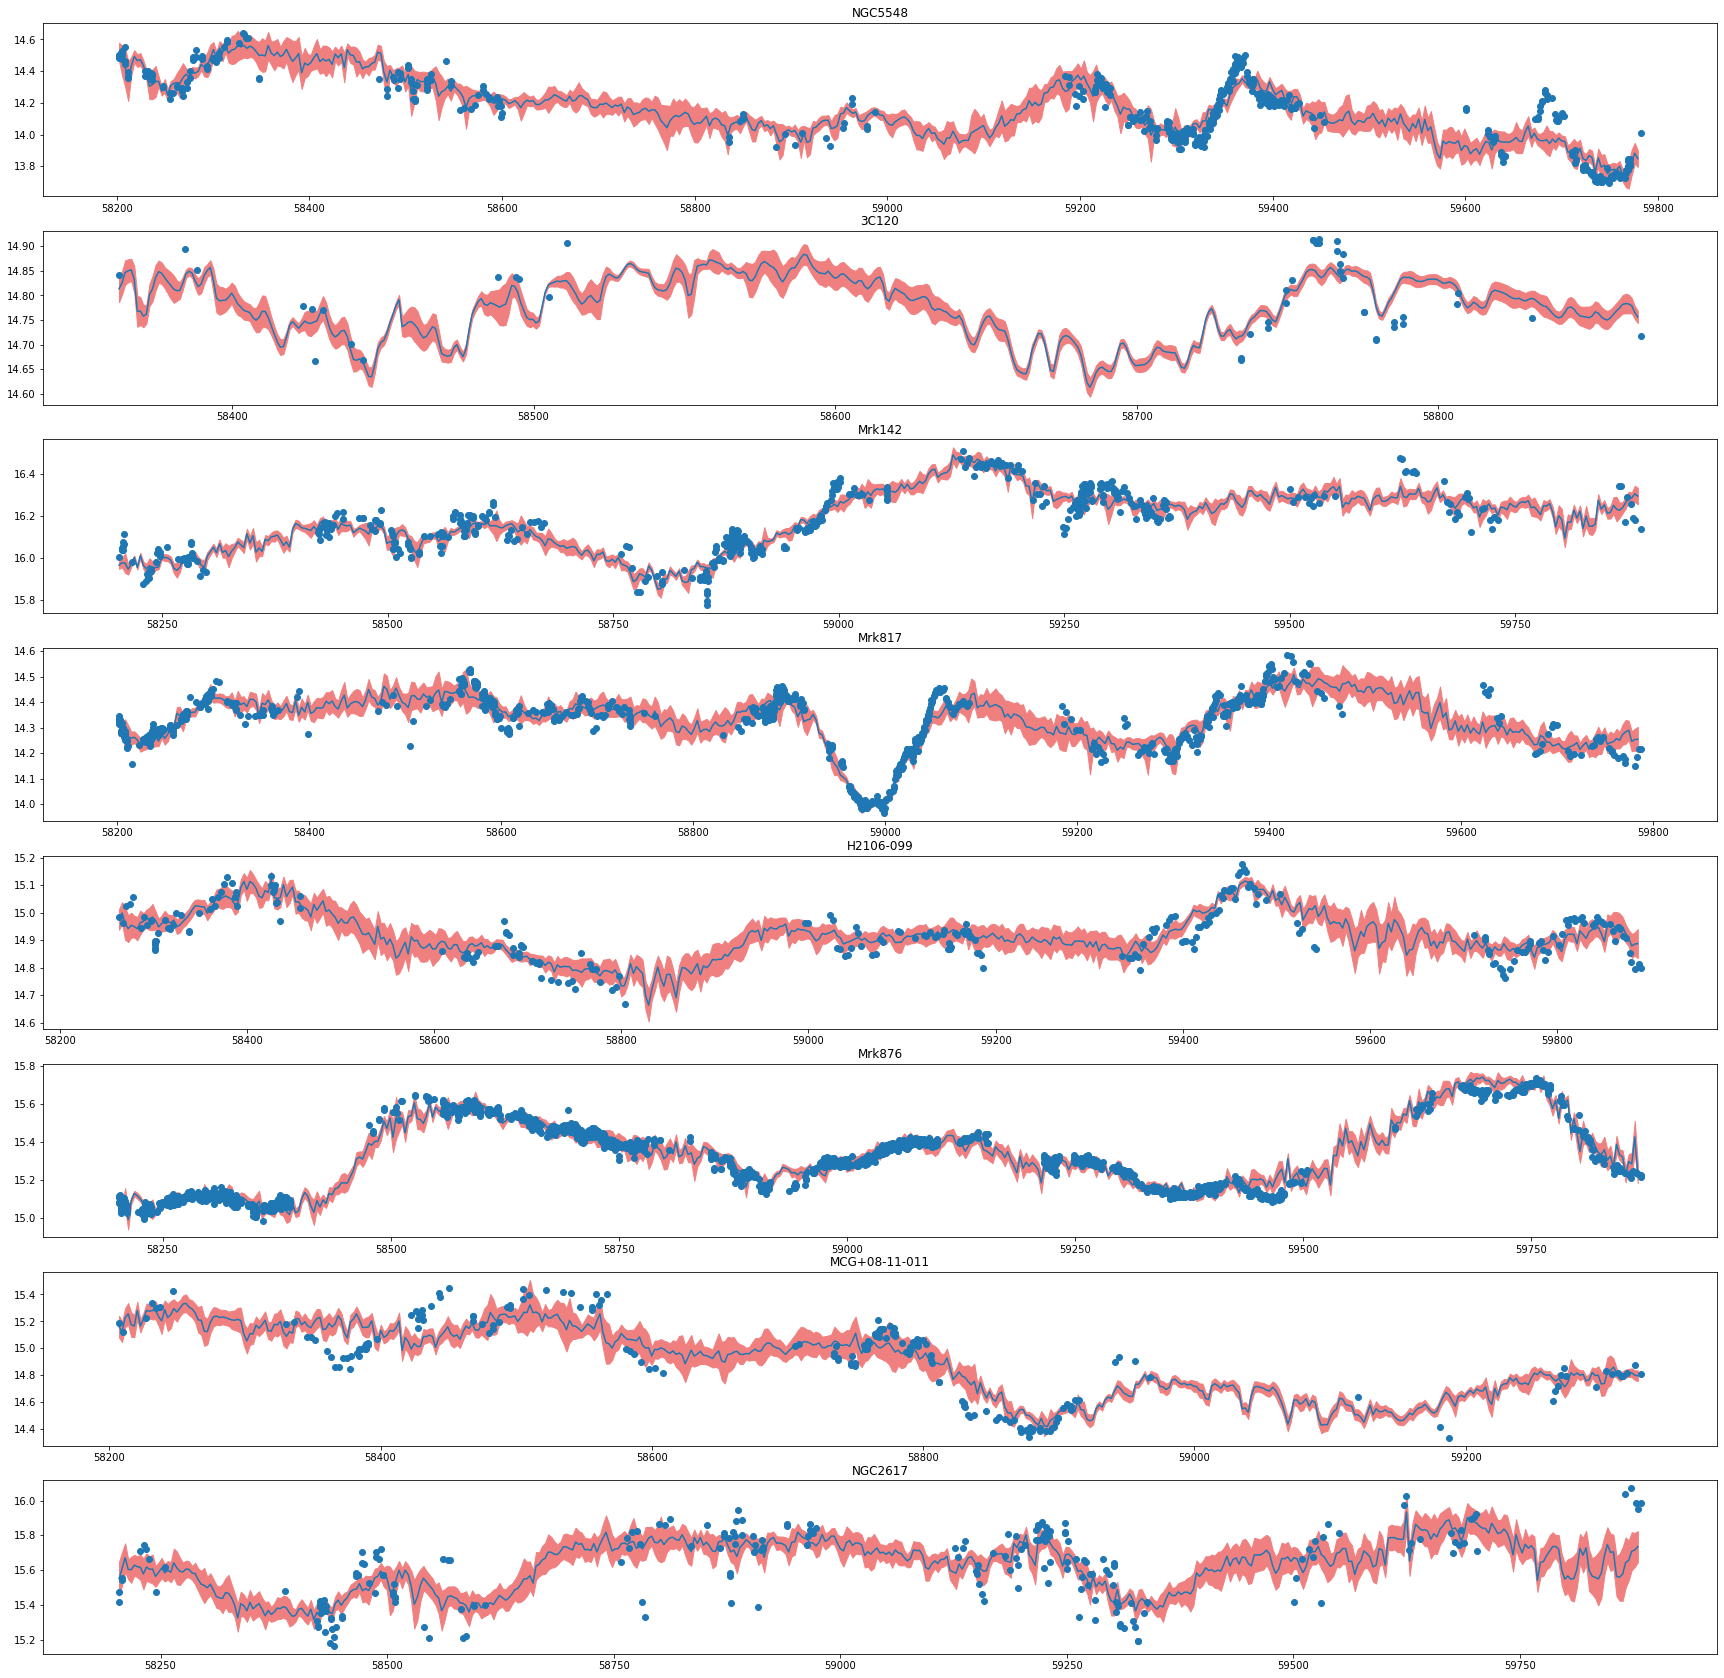

In [21]:
n=len(intps_rm_g)
dims = len(lcs_rm_g.bands)
figsize=(30,30)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(n):
   
    ax[ex,0].set_title(f'{lcs_rm_g.valid_files_df.index[ex]}')
    for band in range(dims):
        t=intps_rm_g[ex,band,:,0]
        y=intps_rm_g[ex,band,:,1]
        yerr=intps_rm_g[ex,band,:,2]
        ax[ex,band].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
        #ax[ex,band].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
        ax[ex,band].plot(t,y)
        if lcs_rm_g.unnormalized_data[ex][band][:,1].any(): # not missing light curves
            ax[ex,band].scatter(lcs_rm_g.unnormalized_data[ex][band][:,0], lcs_rm_g.unnormalized_data[ex][band][:,1])
            

In [ ]:
# shouldn't have trained on non-messy light curves, too late
# 

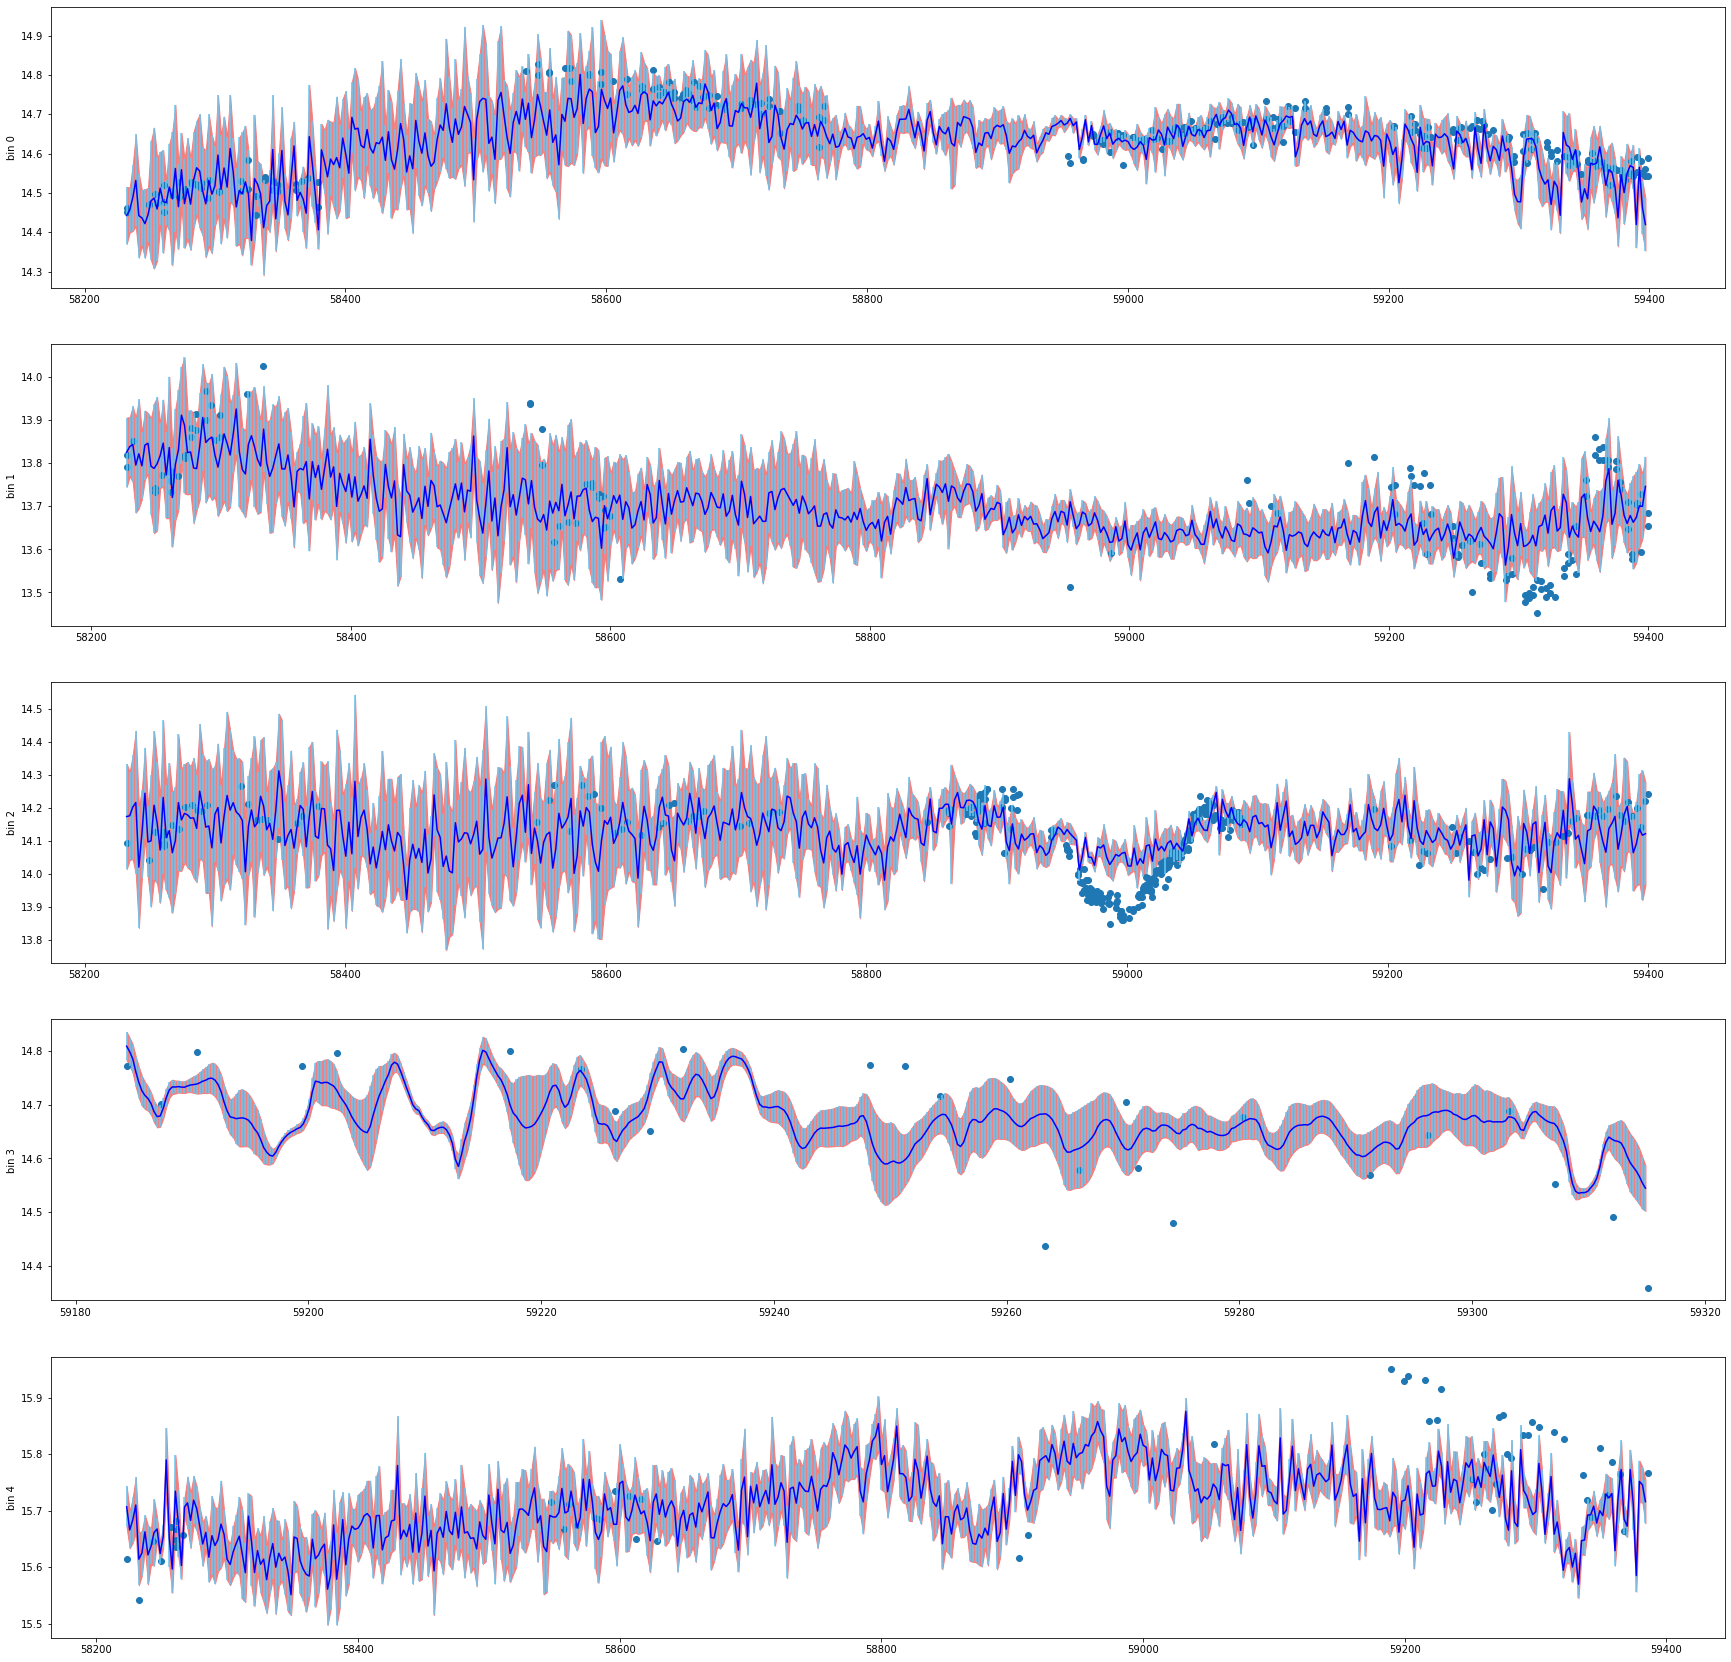

In [19]:
n=len(intps_rm_i)
dims = len(lcs_rm_i.bands)
figsize=(30,30)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(n):
    ax[ex,0].set_ylabel(f'bin {ex}')
    for band in range(dims):
        t=intps_rm_i[ex,band,:,0]
        y=intps_rm_i[ex,band,:,1]
        yerr=intps_rm_i[ex,band,:,2]
        ax[ex,band].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
        ax[ex,band].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
        #ax[ex,band].scatter(t,y)
        if lcs_rm_i.unnormalized_data[ex][band][:,1].any(): # not missing light curves
            ax[ex,band].scatter(lcs_rm_i.unnormalized_data[ex][band][:,0], lcs_rm_i.unnormalized_data[ex][band][:,1])
           

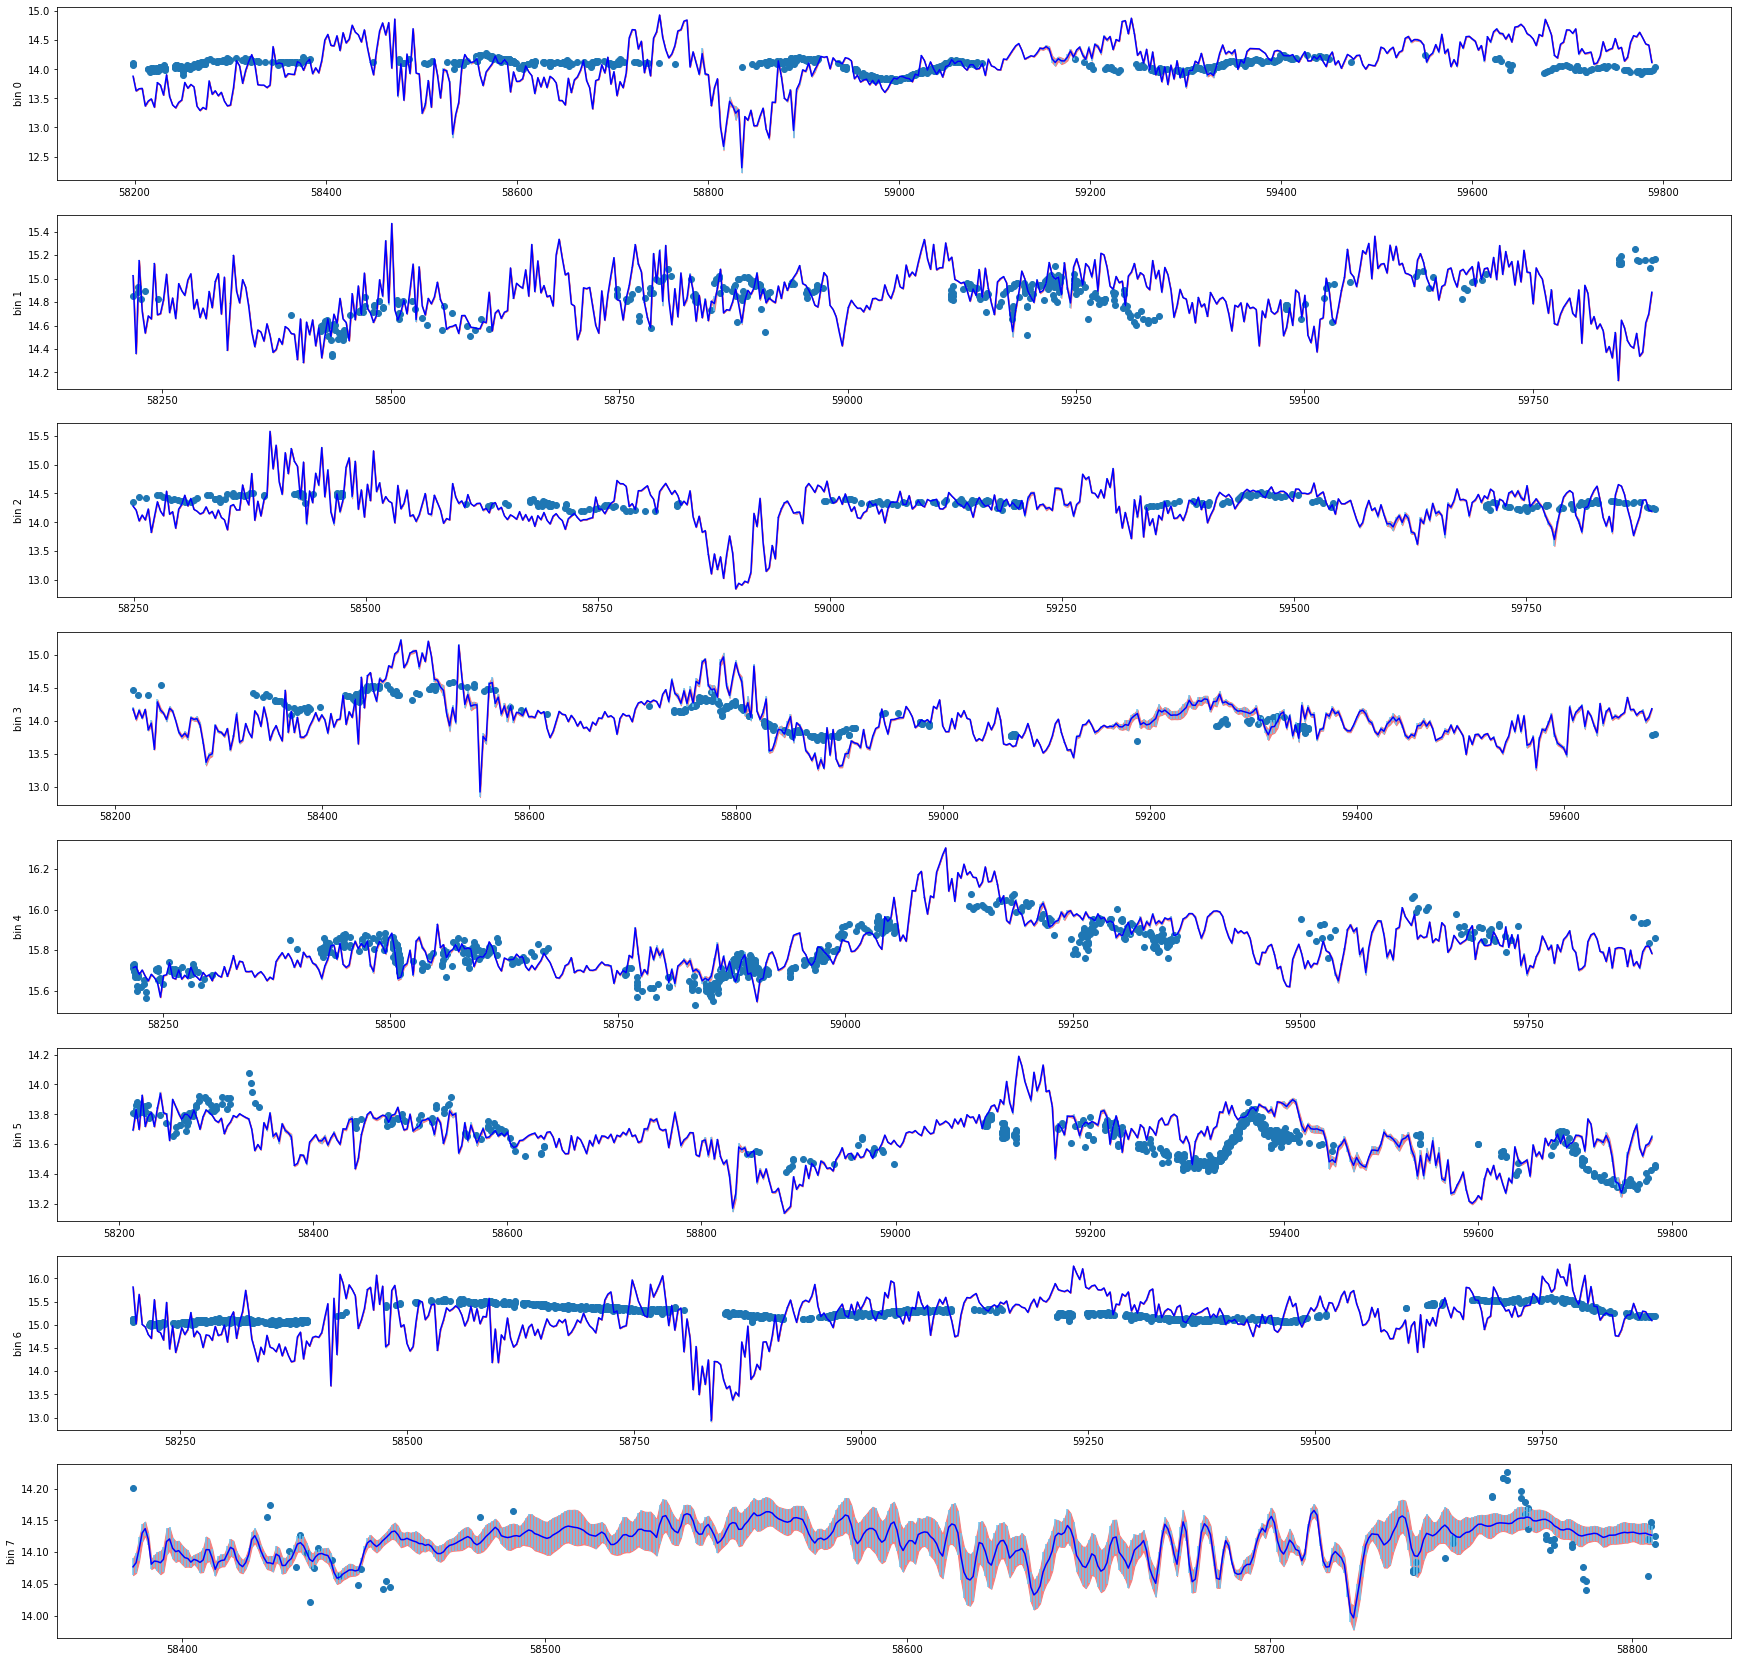

In [20]:
n=len(intps_rm_r)
dims = len(lcs_rm_r.bands)
figsize=(30,30)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(n):
    ax[ex,0].set_ylabel(f'bin {ex}')
    for band in range(dims):
        t=intps_rm_r[ex,band,:,0]
        y=intps_rm_r[ex,band,:,1]
        yerr=intps_rm_r[ex,band,:,2]
        ax[ex,band].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
        ax[ex,band].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
        #ax[ex,band].scatter(t,y)
        if lcs_rm_r.unnormalized_data[ex][band][:,1].any(): # not missing light curves
            ax[ex,band].scatter(lcs_rm_r.unnormalized_data[ex][band][:,0], lcs_rm_r.unnormalized_data[ex][band][:,1])
           

In [74]:
save_folder = 'gri_interps'
if not os.path.isdir(save_folder): os.mkdir(save_folder)
obj_names = lcs.valid_files_df.index
for i in range(len(interps)):
    for j,band in enumerate(lcs.bands):
        np.savetxt(os.path.join(save_folder,f'{obj_names[i]}_{band}'), interps[i,j])